# 시카고 범죄율을 예측해 보자 ( Facebook 의 Prophet 라이브러리 활용 )





# STEP #0: PROBLEM STATEMENT

- The Chicago Crime dataset : 2001 ~ 2017. 
- Datasource: 캐글 https://www.kaggle.com/currie32/crimes-in-*chicago*
- Dataset contains the following columns: 
    - ID: Unique identifier for the record.
    - Case Number: The Chicago Police Department RD Number (Records Division Number), which is unique to the incident.
    - Date: Date when the incident occurred.
    - Block: address where the incident occurred
    - IUCR: The Illinois Unifrom Crime Reporting code.
    - Primary Type: The primary description of the IUCR code.
    - Description: The secondary description of the IUCR code, a subcategory of the primary description.
    - Location Description: Description of the location where the incident occurred.
    - Arrest: Indicates whether an arrest was made.
    - Domestic: Indicates whether the incident was domestic-related as defined by the Illinois Domestic Violence Act.
    - Beat: Indicates the beat where the incident occurred. A beat is the smallest police geographic area – each beat has a dedicated police beat car. 
    - District: Indicates the police district where the incident occurred. 
    - Ward: The ward (City Council district) where the incident occurred. 
    - Community Area: Indicates the community area where the incident occurred. Chicago has 77 community areas. 
    - FBI Code: Indicates the crime classification as outlined in the FBI's National Incident-Based Reporting System (NIBRS). 
    - X Coordinate: The x coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection. 
    - Y Coordinate: The y coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection. 
    - Year: Year the incident occurred.
    - Updated On: Date and time the record was last updated.
    - Latitude: The latitude of the location where the incident occurred. This location is shifted from the actual location for partial redaction but falls on the same block.
    - Longitude: The longitude of the location where the incident occurred. This location is shifted from the actual location for partial redaction but falls on the same block.
    - Location: The location where the incident occurred in a format that allows for creation of maps and other geographic operations on this data portal. This location is shifted from the actual location for partial redaction but falls on the same block.


### 페이스북에서 만든 오픈소스 Prophet 라이브러리

- Seasonal time series data를 분석할 수 있는 딥러닝 라이브러리다. 

- 프로펫 공식 레이지 : https://research.fb.com/prophet-forecasting-at-scale/
https://facebook.github.io/prophet/docs/quick_start.html#python-api


### 코랩에는 자동으로 prophet이 설치되어 있다. 따라서 다른 환경에서 설치 되어있지 않다면, 다음처럼 설치하면 된다.

- pip install fbprophet
     
- 위의 pip 설치 시 에러가 나면 다음처럼 설치해 준다 : 
    conda install -c conda-forge fbprophet


# STEP #1: IMPORTING DATA

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import random
import seaborn as sns
from prophet import Prophet


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

In [4]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/ml_plus/data')

In [ ]:
# Chicago_Crimes_2005_to_2007.csv 
# Chicago_Crimes_2008_to_2011.csv
# Chicago_Crimes_2012_to_2017.csv 파일을 읽되, 
# 각각 파라미터 error_bad_lines=False 추가 해준다.


In [9]:
chicago_df_1 =  pd.read_csv('Chicago_Crimes_2005_to_2007.csv', 
                            error_bad_lines=False, 
                            index_col = 0)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
b'Skipping line 533719: expected 23 fields, saw 24\n'


In [10]:
chicago_df_2 =  pd.read_csv('Chicago_Crimes_2008_to_2011.csv', 
                            error_bad_lines=False, 
                            index_col = 0)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
b'Skipping line 1149094: expected 23 fields, saw 41\n'


In [11]:
chicago_df_3 =  pd.read_csv('Chicago_Crimes_2012_to_2017.csv', 
                            error_bad_lines=False, 
                            index_col = 0)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
# 데이터 모양을 보고, 이상한 부분은 처리해 준다.

In [12]:
# 위의 3개 데이터프레임을 하나로 합친다. 

chicago_df =  pd.concat( [chicago_df_1, chicago_df_2, chicago_df_3]  )


In [13]:
chicago_df.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,4673626,HM274058,04/02/2006 01:00:00 PM,055XX N MANGO AVE,2825,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,False,...,45.0,11.0,26,1136872.0,1936499.0,2006,04/15/2016 08:55:02 AM,41.981913,-87.771996,"(41.981912692, -87.771996382)"
1,4673627,HM202199,02/26/2006 01:40:48 PM,065XX S RHODES AVE,2017,NARCOTICS,MANU/DELIVER:CRACK,SIDEWALK,True,False,...,20.0,42.0,18,1181027.0,1861693.0,2006,04/15/2016 08:55:02 AM,41.775733,-87.611920,"(41.775732538, -87.611919814)"
2,4673628,HM113861,01/08/2006 11:16:00 PM,013XX E 69TH ST,051A,ASSAULT,AGGRAVATED: HANDGUN,OTHER,False,False,...,5.0,69.0,04A,1186023.0,1859609.0,2006,04/15/2016 08:55:02 AM,41.769897,-87.593671,"(41.769897392, -87.593670899)"
4,4673629,HM274049,04/05/2006 06:45:00 PM,061XX W NEWPORT AVE,0460,BATTERY,SIMPLE,RESIDENCE,False,False,...,38.0,17.0,08B,1134772.0,1922299.0,2006,04/15/2016 08:55:02 AM,41.942984,-87.780057,"(41.942984005, -87.780056951)"
5,4673630,HM187120,02/17/2006 09:03:14 PM,037XX W 60TH ST,1811,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,ALLEY,True,False,...,13.0,65.0,18,1152412.0,1864560.0,2006,04/15/2016 08:55:02 AM,41.784211,-87.716745,"(41.784210853, -87.71674491)"


In [14]:
chicago_df.shape

(6017767, 22)

# STEP #2: EXPLORING THE DATASET  

In [15]:
# Let's view the head of the training dataset
chicago_df.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,4673626,HM274058,04/02/2006 01:00:00 PM,055XX N MANGO AVE,2825,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,False,...,45.0,11.0,26,1136872.0,1936499.0,2006,04/15/2016 08:55:02 AM,41.981913,-87.771996,"(41.981912692, -87.771996382)"
1,4673627,HM202199,02/26/2006 01:40:48 PM,065XX S RHODES AVE,2017,NARCOTICS,MANU/DELIVER:CRACK,SIDEWALK,True,False,...,20.0,42.0,18,1181027.0,1861693.0,2006,04/15/2016 08:55:02 AM,41.775733,-87.611920,"(41.775732538, -87.611919814)"
2,4673628,HM113861,01/08/2006 11:16:00 PM,013XX E 69TH ST,051A,ASSAULT,AGGRAVATED: HANDGUN,OTHER,False,False,...,5.0,69.0,04A,1186023.0,1859609.0,2006,04/15/2016 08:55:02 AM,41.769897,-87.593671,"(41.769897392, -87.593670899)"
4,4673629,HM274049,04/05/2006 06:45:00 PM,061XX W NEWPORT AVE,0460,BATTERY,SIMPLE,RESIDENCE,False,False,...,38.0,17.0,08B,1134772.0,1922299.0,2006,04/15/2016 08:55:02 AM,41.942984,-87.780057,"(41.942984005, -87.780056951)"
5,4673630,HM187120,02/17/2006 09:03:14 PM,037XX W 60TH ST,1811,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,ALLEY,True,False,...,13.0,65.0,18,1152412.0,1864560.0,2006,04/15/2016 08:55:02 AM,41.784211,-87.716745,"(41.784210853, -87.71674491)"


In [16]:
# Let's view the last elements in the training dataset
chicago_df.tail()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
6250330,10508679,HZ250507,05/03/2016 11:33:00 PM,026XX W 23RD PL,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,True,True,...,28.0,30.0,08B,1159105.0,1888300.0,2016,05/10/2016 03:56:50 PM,41.849222,-87.691556,"(41.849222028, -87.69155551)"
6251089,10508680,HZ250491,05/03/2016 11:30:00 PM,073XX S HARVARD AVE,1310,CRIMINAL DAMAGE,TO PROPERTY,APARTMENT,True,True,...,17.0,69.0,14,1175230.0,1856183.0,2016,05/10/2016 03:56:50 PM,41.760744,-87.633335,"(41.760743949, -87.63333531)"
6251349,10508681,HZ250479,05/03/2016 12:15:00 AM,024XX W 63RD ST,041A,BATTERY,AGGRAVATED: HANDGUN,SIDEWALK,False,False,...,15.0,66.0,04B,1161027.0,1862810.0,2016,05/10/2016 03:56:50 PM,41.779235,-87.685207,"(41.779234743, -87.685207125)"
6253257,10508690,HZ250370,05/03/2016 09:07:00 PM,082XX S EXCHANGE AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,SIDEWALK,False,True,...,7.0,46.0,08B,1197261.0,1850727.0,2016,05/10/2016 03:56:50 PM,41.745252,-87.552773,"(41.745251975, -87.552773464)"
6253474,10508692,HZ250517,05/03/2016 11:38:00 PM,001XX E 75TH ST,5007,OTHER OFFENSE,OTHER WEAPONS VIOLATION,PARKING LOT/GARAGE(NON.RESID.),True,False,...,6.0,69.0,26,1178696.0,1855324.0,2016,05/10/2016 03:56:50 PM,41.758309,-87.620658,"(41.75830866, -87.620658418)"


### 비어있는 데이터가 얼마나 되는지 확인하시오.

In [17]:
chicago_df.isna().sum()

ID                          0
Case Number                 7
Date                        0
Block                       0
IUCR                        0
Primary Type                0
Description                 0
Location Description     1974
Arrest                      0
Domestic                    0
Beat                        0
District                   89
Ward                       92
Community Area           1844
FBI Code                    0
X Coordinate            74882
Y Coordinate            74882
Year                        0
Updated On                  0
Latitude                74882
Longitude               74882
Location                74882
dtype: int64

### 다음 컬럼들을 삭제하시오.

'Case Number', 'Case Number', 'IUCR', 'X Coordinate', 'Y Coordinate','Updated On','Year', 'FBI Code', 'Beat','Ward','Community Area', 'Location', 'District', 'Latitude' , 'Longitude'

In [19]:
cols = ['Case Number', 'Case Number', 'IUCR', 'X Coordinate', 'Y Coordinate','Updated On','Year', 'FBI Code', 'Beat','Ward','Community Area', 'Location', 'District', 'Latitude' , 'Longitude']

In [21]:
chicago_df.drop( cols , axis = 1 , inplace = True)

### Date 컬럼을 보니, 날짜 형식으로 되어있다. 이를 파이썬이 이해할 수 있는 날짜로 바꿔서 다시 Date 컬럼에 저장하시오. 

In [23]:
chicago_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6017767 entries, 0 to 6253474
Data columns (total 8 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   ID                    int64 
 1   Date                  object
 2   Block                 object
 3   Primary Type          object
 4   Description           object
 5   Location Description  object
 6   Arrest                bool  
 7   Domestic              bool  
dtypes: bool(2), int64(1), object(5)
memory usage: 332.9+ MB


In [24]:
chicago_df['Date']

0          04/02/2006 01:00:00 PM
1          02/26/2006 01:40:48 PM
2          01/08/2006 11:16:00 PM
4          04/05/2006 06:45:00 PM
5          02/17/2006 09:03:14 PM
                    ...          
6250330    05/03/2016 11:33:00 PM
6251089    05/03/2016 11:30:00 PM
6251349    05/03/2016 12:15:00 AM
6253257    05/03/2016 09:07:00 PM
6253474    05/03/2016 11:38:00 PM
Name: Date, Length: 6017767, dtype: object

In [26]:
chicago_df['Date'] = pd.to_datetime( chicago_df['Date'] , format='%m/%d/%Y %I:%M:%S %p' )

In [27]:
chicago_df

,ID,Date,Block,Primary Type,Description,Location Description,Arrest,Domestic
0,4673626,2006-04-02 13:00:00,055XX N MANGO AVE,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,False
1,4673627,2006-02-26 13:40:48,065XX S RHODES AVE,NARCOTICS,MANU/DELIVER:CRACK,SIDEWALK,True,False
2,4673628,2006-01-08 23:16:00,013XX E 69TH ST,ASSAULT,AGGRAVATED: HANDGUN,OTHER,False,False
4,4673629,2006-04-05 18:45:00,061XX W NEWPORT AVE,BATTERY,SIMPLE,RESIDENCE,False,False
5,4673630,2006-02-17 21:03:14,037XX W 60TH ST,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,ALLEY,True,False
...,...,...,...,...,...,...,...,...
6250330,10508679,2016-05-03 23:33:00,026XX W 23RD PL,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,True,True
6251089,10508680,2016-05-03 23:30:00,073XX S HARVARD AVE,CRIMINAL DAMAGE,TO PROPERTY,APARTMENT,True,True
6251349,10508681,2016-05-03 00:15:00,024XX W 63RD ST,BATTERY,AGGRAVATED: HANDGUN,SIDEWALK,False,False
6253257,10508690,2016-05-03 21:07:00,082XX S EXCHANGE AVE,BATTERY,DOMESTIC BATTERY SIMPLE,SIDEWALK,False,True


In [28]:
chicago_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6017767 entries, 0 to 6253474
Data columns (total 8 columns):
 #   Column                Dtype         
---  ------                -----         
 0   ID                    int64         
 1   Date                  datetime64[ns]
 2   Block                 object        
 3   Primary Type          object        
 4   Description           object        
 5   Location Description  object        
 6   Arrest                bool          
 7   Domestic              bool          
dtypes: bool(2), datetime64[ns](1), int64(1), object(4)
memory usage: 332.9+ MB


In [ ]:
# 범죄가 일어난 시간이, Date 컬럼에 있다.
# 이 정보로부터, 요일정보를 뽑아서
# 각 요일별로, 범죄건수를 보여주세요.

In [32]:
chicago_df['weekday'] = chicago_df['Date'].dt.weekday

In [34]:
chicago_df['weekday'].value_counts()

4    910373
2    870841
1    865340
3    860425
5    858153
0    843525
6    809110
Name: weekday, dtype: int64

In [37]:
chicago_df['weekday'] =  chicago_df['Date'].dt.strftime('%A')

In [38]:
chicago_df['weekday'].value_counts()

Friday       910373
Wednesday    870841
Tuesday      865340
Thursday     860425
Saturday     858153
Monday       843525
Sunday       809110
Name: weekday, dtype: int64

### Date 컬럼을 인덱스로 만드시오.

In [ ]:
# 그룹바이함수를 이용해서는, 날짜 데이터로 바로
# 년단위, 월단위, 일단위, 시단위, 분단위 , 초단위 등으로 묶어라
# 라고 할수 없다!!!

# 따라서, 먼저 Date 컬럼을 인덱스로 만들어 준다.
# 그러면, resample 함수를 사용할수 있게 된다.
# 바로 이 함수가, 년단위, 월단위 등등으로 데이터를 묶어서 처리가 가능하다.

In [40]:
chicago_df.index = chicago_df['Date']

In [41]:
chicago_df

,ID,Date,Block,Primary Type,Description,Location Description,Arrest,Domestic,weekday
Date,,,,,,,,,
2006-04-02 13:00:00,4673626,2006-04-02 13:00:00,055XX N MANGO AVE,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,False,Sunday
2006-02-26 13:40:48,4673627,2006-02-26 13:40:48,065XX S RHODES AVE,NARCOTICS,MANU/DELIVER:CRACK,SIDEWALK,True,False,Sunday
2006-01-08 23:16:00,4673628,2006-01-08 23:16:00,013XX E 69TH ST,ASSAULT,AGGRAVATED: HANDGUN,OTHER,False,False,Sunday
2006-04-05 18:45:00,4673629,2006-04-05 18:45:00,061XX W NEWPORT AVE,BATTERY,SIMPLE,RESIDENCE,False,False,Wednesday
2006-02-17 21:03:14,4673630,2006-02-17 21:03:14,037XX W 60TH ST,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,ALLEY,True,False,Friday
...,...,...,...,...,...,...,...,...,...
2016-05-03 23:33:00,10508679,2016-05-03 23:33:00,026XX W 23RD PL,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,True,True,Tuesday
2016-05-03 23:30:00,10508680,2016-05-03 23:30:00,073XX S HARVARD AVE,CRIMINAL DAMAGE,TO PROPERTY,APARTMENT,True,True,Tuesday
2016-05-03 00:15:00,10508681,2016-05-03 00:15:00,024XX W 63RD ST,BATTERY,AGGRAVATED: HANDGUN,SIDEWALK,False,False,Tuesday


### 범죄 유형의 갯수를 세고, 가장 많은것부터 내림차순으로 보여주세요.  

In [43]:
chicago_df['Primary Type'].nunique()

34

In [44]:
chicago_df['Primary Type'].unique()

array(['OTHER OFFENSE', 'NARCOTICS', 'ASSAULT', 'BATTERY', 'THEFT',
       'CRIMINAL TRESPASS', 'MOTOR VEHICLE THEFT', 'ROBBERY',
       'DECEPTIVE PRACTICE', 'CRIMINAL DAMAGE', 'BURGLARY',
       'INTIMIDATION', 'PROSTITUTION', 'SEX OFFENSE',
       'PUBLIC PEACE VIOLATION', 'CRIM SEXUAL ASSAULT',
       'WEAPONS VIOLATION', 'INTERFERENCE WITH PUBLIC OFFICER',
       'OFFENSE INVOLVING CHILDREN', 'LIQUOR LAW VIOLATION', 'KIDNAPPING',
       'STALKING', 'GAMBLING', 'ARSON', 'PUBLIC INDECENCY',
       'OTHER NARCOTIC VIOLATION', 'OBSCENITY', 'HOMICIDE', 'RITUALISM',
       'NON-CRIMINAL', 'HUMAN TRAFFICKING',
       'CONCEALED CARRY LICENSE VIOLATION', 'NON - CRIMINAL',
       'NON-CRIMINAL (SUBJECT SPECIFIED)'], dtype=object)

In [45]:
chicago_df['Primary Type'].value_counts()

THEFT                                1245111
BATTERY                              1079178
CRIMINAL DAMAGE                       702702
NARCOTICS                             674831
BURGLARY                              369056
OTHER OFFENSE                         368169
ASSAULT                               360244
MOTOR VEHICLE THEFT                   271624
ROBBERY                               229467
DECEPTIVE PRACTICE                    225180
CRIMINAL TRESPASS                     171596
PROSTITUTION                           60735
WEAPONS VIOLATION                      60335
PUBLIC PEACE VIOLATION                 48403
OFFENSE INVOLVING CHILDREN             40260
CRIM SEXUAL ASSAULT                    22789
SEX OFFENSE                            20172
GAMBLING                               14755
INTERFERENCE WITH PUBLIC OFFICER       14009
LIQUOR LAW VIOLATION                   12129
ARSON                                   9269
HOMICIDE                                5879
KIDNAPPING

### 상위 15개까지만 보여주세요.

In [47]:
top_15 = chicago_df['Primary Type'].value_counts().head(15)

In [48]:
top_15.index

Index(['THEFT', 'BATTERY', 'CRIMINAL DAMAGE', 'NARCOTICS', 'BURGLARY',
       'OTHER OFFENSE', 'ASSAULT', 'MOTOR VEHICLE THEFT', 'ROBBERY',
       'DECEPTIVE PRACTICE', 'CRIMINAL TRESPASS', 'PROSTITUTION',
       'WEAPONS VIOLATION', 'PUBLIC PEACE VIOLATION',
       'OFFENSE INVOLVING CHILDREN'],
      dtype='object')

### 상위 15개의 범죄 유형(Primary Type)의 갯수를, 비주얼라리징 하시오. 

In [49]:
import seaborn as sb

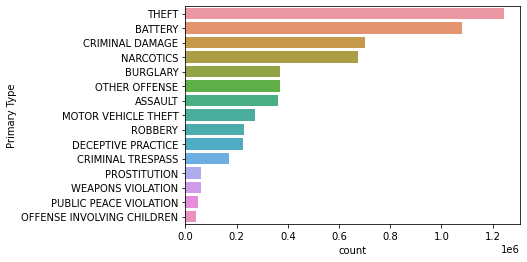

In [51]:
sb.countplot(data = chicago_df, y = 'Primary Type', order = top_15.index)
plt.show()

### 어디에서 가장 범죄가 많이 발생했는지, 범죄 장소(Location Descripton) 로 비주얼라이징 하시오.

### 데이터를 주기별로 분석해 보자

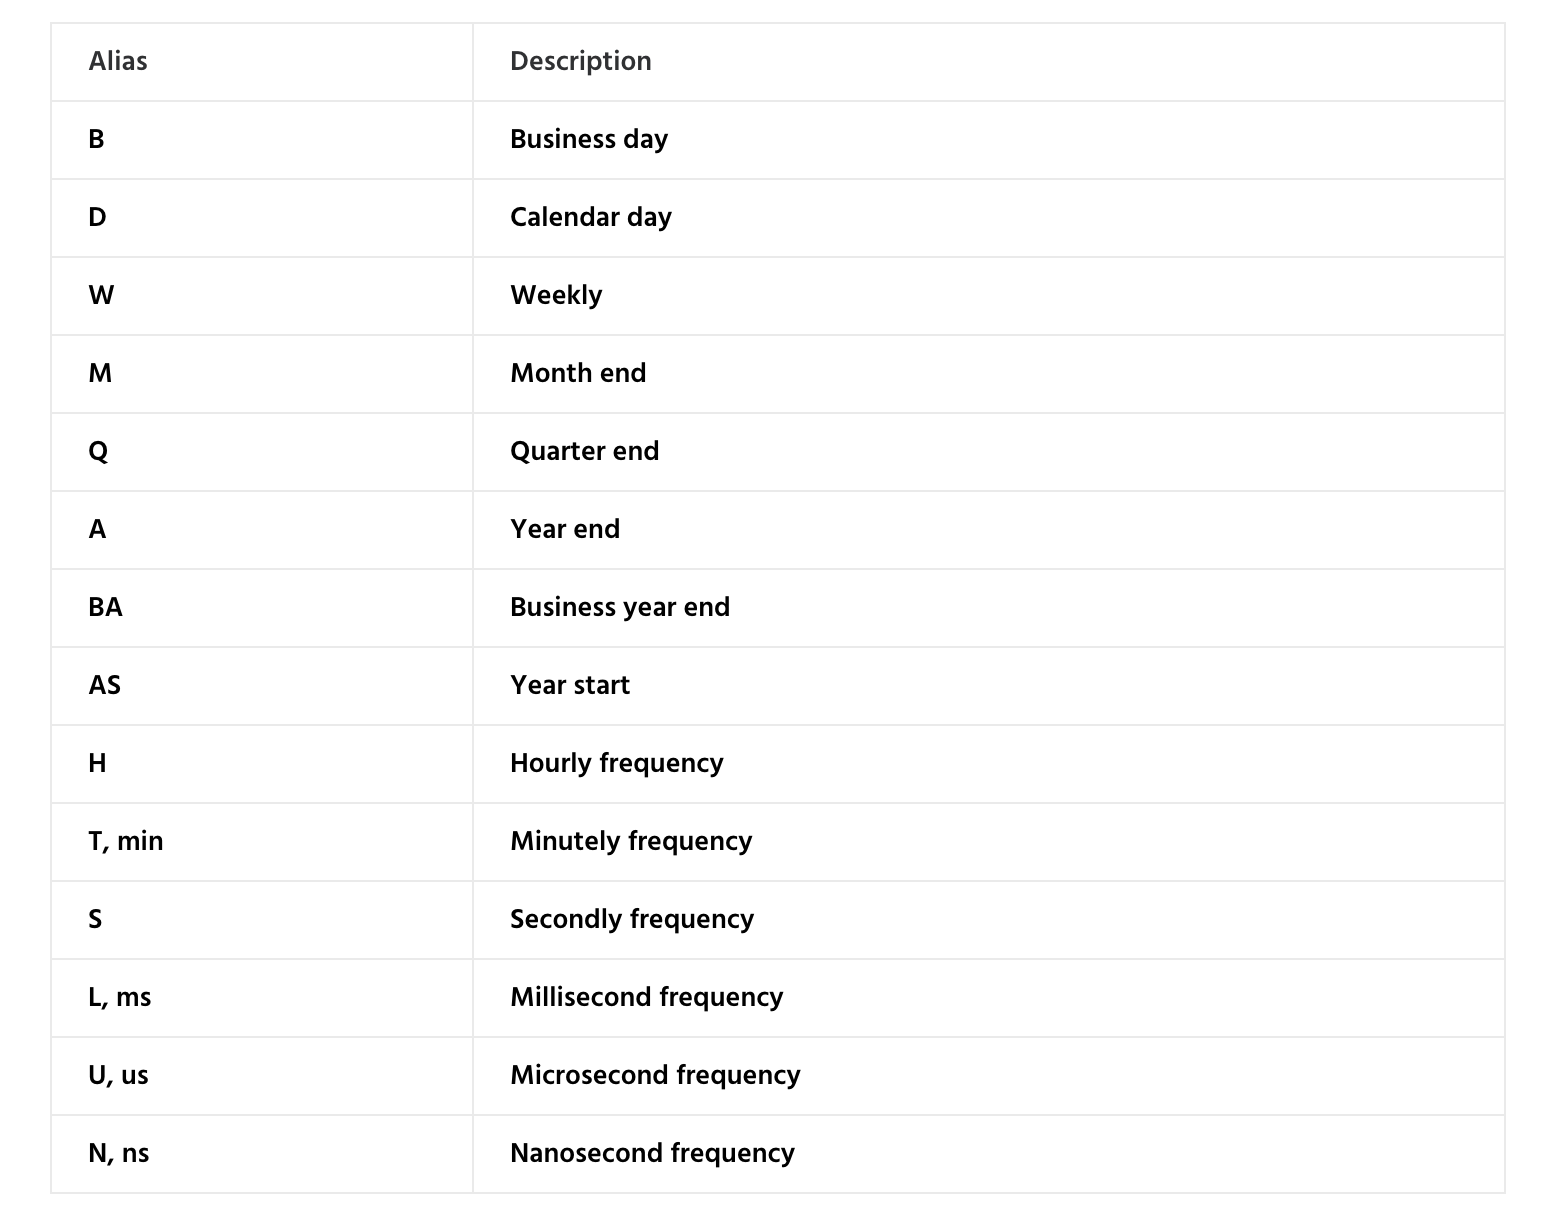

In [55]:
# resample  'Y' 는 년도다. 년도로 리샘플한 후, 각 년도별 몇개의 범죄 데이터를 가지고 있는지 확인한다.
df_year = chicago_df.resample('YS').size()


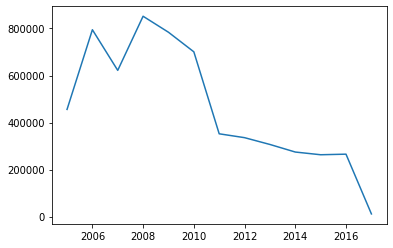

In [56]:
# 위의 데이터를 plot 으로 시각화 한다. 범죄횟수를 눈으로 확인하자.
plt.plot(df_year)
plt.show()

In [62]:
chicago_df.sort_index().tail()

,ID,Date,Block,Primary Type,Description,Location Description,Arrest,Domestic,weekday
Date,,,,,,,,,
2017-01-18 23:30:00,10820633,2017-01-18 23:30:00,116XX S LOWE AVE,BATTERY,DOMESTIC BATTERY SIMPLE,SIDEWALK,False,True,Wednesday
2017-01-18 23:35:00,10820662,2017-01-18 23:35:00,028XX W SHAKESPEARE AVE,ROBBERY,VEHICULAR HIJACKING,ALLEY,False,False,Wednesday
2017-01-18 23:40:00,10821699,2017-01-18 23:40:00,010XX W WILSON AVE,ROBBERY,ARMED: HANDGUN,STREET,False,False,Wednesday
2017-01-18 23:45:00,10820646,2017-01-18 23:45:00,004XX N HOMAN AVE,WEAPONS VIOLATION,UNLAWFUL POSS OF HANDGUN,SIDEWALK,True,False,Wednesday
2017-01-18 23:49:00,10820691,2017-01-18 23:49:00,034XX W DICKENS AVE,ROBBERY,ARMED: HANDGUN,ALLEY,False,False,Wednesday


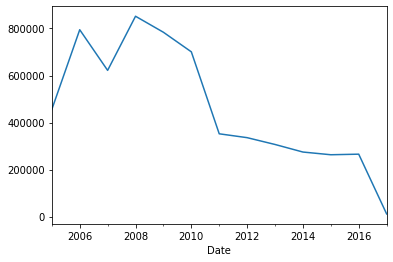

In [65]:
df_year.plot()
plt.show()

In [67]:
# 월별 범죄 발생 건수를 확인하자.
df_month = chicago_df.resample('M').size()

In [69]:
df_month

Date
2005-01-31    33983
2005-02-28    32042
2005-03-31    36970
2005-04-30    38963
2005-05-31    40572
              ...  
2016-09-30    23235
2016-10-31    23314
2016-11-30    21140
2016-12-31    19580
2017-01-31    11357
Freq: M, Length: 145, dtype: int64

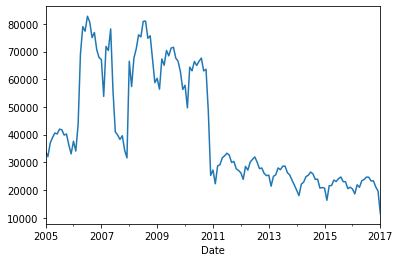

In [68]:
df_month.plot()
plt.show()

In [ ]:
# 월별 범죄 발생 건수도 plot 으로 시각화 하자.


In [70]:
# 분기별 범죄 건수도 확인하자.
df_q = chicago_df.resample('Q').size()

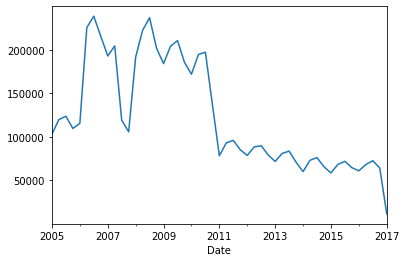

In [71]:
# 분기별 범죄 건수도 시각화 하자.
df_q.plot()
plt.show()

In [72]:
df_day = chicago_df.resample('D').size()

In [73]:
df_day

Date
2005-01-01    2038
2005-01-02    1075
2005-01-03    1091
2005-01-04    1123
2005-01-05     945
              ... 
2017-01-14     649
2017-01-15     600
2017-01-16     611
2017-01-17     659
2017-01-18     655
Freq: D, Length: 4401, dtype: int64

# STEP #3: 데이터 준비

### 일별로 주기로 하여 데이터프레임을 만들고, 인덱스를 리셋하시오.

In [74]:
chicago_prophet =  chicago_df.resample('D').size()

In [75]:
chicago_prophet

Date
2005-01-01    2038
2005-01-02    1075
2005-01-03    1091
2005-01-04    1123
2005-01-05     945
              ... 
2017-01-14     649
2017-01-15     600
2017-01-16     611
2017-01-17     659
2017-01-18     655
Freq: D, Length: 4401, dtype: int64

In [77]:
chicago_prophet = chicago_prophet.reset_index()

### 프로펫 라이브러리를 사용하려면, 날짜 컬럼은 'ds' 로, 에측하려는 수치는 'y'로 바꿔야 합니다(필수).

In [78]:
chicago_prophet

,Date,0
0,2005-01-01,2038
1,2005-01-02,1075
2,2005-01-03,1091
3,2005-01-04,1123
4,2005-01-05,945
...,...,...
4396,2017-01-14,649
4397,2017-01-15,600
4398,2017-01-16,611
4399,2017-01-17,659


In [81]:
chicago_prophet.columns = ['ds' , 'y']

In [82]:
chicago_prophet

,ds,y
0,2005-01-01,2038
1,2005-01-02,1075
2,2005-01-03,1091
3,2005-01-04,1123
4,2005-01-05,945
...,...,...
4396,2017-01-14,649
4397,2017-01-15,600
4398,2017-01-16,611
4399,2017-01-17,659


# STEP #4: Prophet 으로 예측하기

In [84]:
prophet = Prophet()

In [85]:
prophet.fit(chicago_prophet)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnt52l0o9/83ks1497.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnt52l0o9/4mz8b7av.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32871', 'data', 'file=/tmp/tmpnt52l0o9/83ks1497.json', 'init=/tmp/tmpnt52l0o9/4mz8b7av.json', 'output', 'file=/tmp/tmpnt52l0o9/prophet_models7ev5t1f/prophet_model-20230103060807.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:08:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:08:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


### [freq 조절 가능한 문자 ](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases)

[페이스북 프로펫 페이지 예시](https://facebook.github.io/prophet/docs/non-daily_data.html)

In [86]:
# 730 일치로 해서 예측해보자.
future = prophet.make_future_dataframe(periods= 730, freq = 'D')

In [87]:
forecast = prophet.predict(future)

In [88]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2005-01-01,1225.675125,802.623193,1285.079084,1225.675125,1225.675125,-187.016884,-187.016884,-187.016884,-3.020912,-3.020912,-3.020912,-183.995972,-183.995972,-183.995972,0.0,0.0,0.0,1038.658241
1,2005-01-02,1225.631512,726.664054,1217.294328,1225.631512,1225.631512,-257.693454,-257.693454,-257.693454,-80.891351,-80.891351,-80.891351,-176.802103,-176.802103,-176.802103,0.0,0.0,0.0,967.938058
2,2005-01-03,1225.587899,790.214592,1298.113737,1225.587899,1225.587899,-195.782863,-195.782863,-195.782863,-26.076470,-26.076470,-26.076470,-169.706393,-169.706393,-169.706393,0.0,0.0,0.0,1029.805035
3,2005-01-04,1225.544285,820.629554,1306.443798,1225.544285,1225.544285,-154.108636,-154.108636,-154.108636,8.700692,8.700692,8.700692,-162.809328,-162.809328,-162.809328,0.0,0.0,0.0,1071.435650
4,2005-01-05,1225.500672,852.876915,1325.990789,1225.500672,1225.500672,-138.658170,-138.658170,-138.658170,17.552502,17.552502,17.552502,-156.210672,-156.210672,-156.210672,0.0,0.0,0.0,1086.842502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5126,2019-01-14,704.530323,-1491.605078,2949.890843,-1310.831742,3062.234272,-150.157297,-150.157297,-150.157297,-26.076470,-26.076470,-26.076470,-124.080826,-124.080826,-124.080826,0.0,0.0,0.0,554.373027
5127,2019-01-15,704.507683,-1424.333529,3042.768776,-1315.183302,3068.579948,-115.366493,-115.366493,-115.366493,8.700692,8.700692,8.700692,-124.067186,-124.067186,-124.067186,0.0,0.0,0.0,589.141189
5128,2019-01-16,704.485042,-1426.975432,2971.041374,-1319.534861,3074.925624,-107.366825,-107.366825,-107.366825,17.552502,17.552502,17.552502,-124.919327,-124.919327,-124.919327,0.0,0.0,0.0,597.118217
5129,2019-01-17,704.462402,-1461.517465,3001.471494,-1323.886421,3081.271300,-124.565981,-124.565981,-124.565981,2.050915,2.050915,2.050915,-126.616896,-126.616896,-126.616896,0.0,0.0,0.0,579.896421


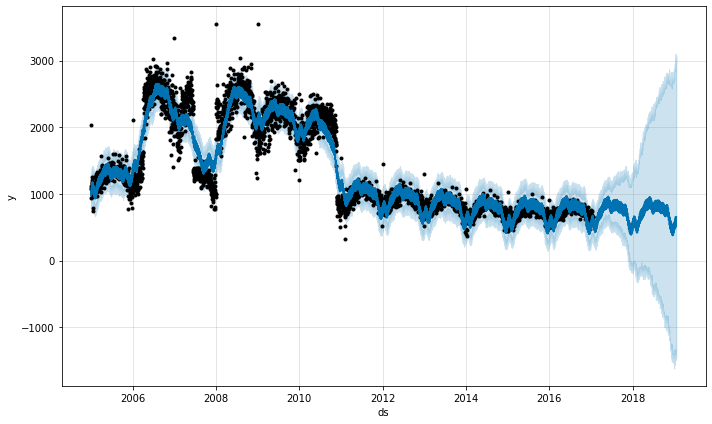

In [90]:
prophet.plot(forecast)
plt.savefig('chart11.jpg')

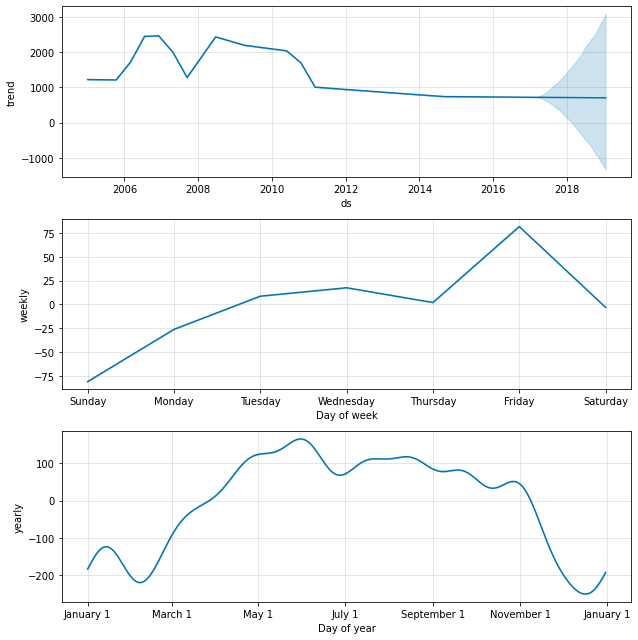

In [91]:
prophet.plot_components(forecast)
plt.savefig('chart12.jpg')

In [ ]:
# 월별 데이터로 예측!  36개월치로 예측 

In [92]:
df_month

Date
2005-01-31    33983
2005-02-28    32042
2005-03-31    36970
2005-04-30    38963
2005-05-31    40572
              ...  
2016-09-30    23235
2016-10-31    23314
2016-11-30    21140
2016-12-31    19580
2017-01-31    11357
Freq: M, Length: 145, dtype: int64